# Amelioration du modele

Afin d'ameliorer mon modele, j'ajoute un jeu de données par ville bresilienne

Je pense que les zones densément peuplés sont mieux désservies, les informations de population par exemple sont interessantes

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
import os

from unidecode import unidecode

In [2]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
df = pd.read_sql('select * from base_modele_ameliore', con, index_col='index')

con.close()

df.head()

,distance,estimated_delay,price,freight_value,customer_city,customer_state,seller_city,seller_state,weight,volume,...,February,January,July,June,March,May,November,October,September,shipping_delay
index,,,,,,,,,,,,,,,,,,,,,
0,2400.386719,28.566238,21.99,14.110000,rio de janeiro,RJ,sao paulo,SP,125.0,1040.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926
1,2653.626709,22.309410,412.00,27.719999,atibaia,SP,curitiba,PR,6000.0,36000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.149213
2,2653.626709,22.309410,412.00,27.719999,atibaia,SP,curitiba,PR,6000.0,36000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.149213
3,2596.499512,17.523668,420.00,24.240000,sao paulo,SP,curitiba,PR,3000.0,18000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.436667
4,3061.440186,22.359861,412.00,26.260000,belo horizonte,MG,curitiba,PR,3000.0,18000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.238160


### Recuperation du nombre de compagnies de transport

In [3]:
df_pop = pd.read_csv('modele_amelioration_dataset/BRAZIL_CITIES.csv', sep=';')

# Filtre les colonnes interessantes
df_pop_cols = ['CITY', 'STATE', 'CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df_pop = df_pop[df_pop_cols]

# Creation d'un id
df_pop.CITY = df_pop.CITY.apply(str.lower).apply(unidecode)
df_pop['id'] = df_pop.CITY + ' ' + df_pop.STATE
df_pop_cols = ['CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df_pop = df_pop.drop(columns=['CITY', 'STATE'])

df_pop.id.head(1)

0    abadia de goias GO
Name: id, dtype: object

In [4]:
df['customer_id'] = df.customer_city + ' ' + df.customer_state
df['seller_id'] = df.seller_city + ' ' + df.seller_state

df = df.merge(df_pop, how='left', left_on='customer_id', right_on='id')
df.head(1)

,distance,estimated_delay,price,freight_value,customer_city,customer_state,seller_city,seller_state,weight,volume,...,customer_id,seller_id,CAPITAL,IBGE_RES_POP,ESTIMATED_POP,RURAL_URBAN,POP_GDP,COMP_H,POST_OFFICES,id
0,2400.386719,28.566238,21.99,14.11,rio de janeiro,RJ,sao paulo,SP,125.0,1040.0,...,rio de janeiro RJ,sao paulo SP,1.0,6320446.0,6688927.0,Urbano,6498837.0,4825.0,120.0,rio de janeiro RJ


(<AxesSubplot:>,
 CAPITAL         -0.054407
 IBGE_RES_POP    -0.197762
 ESTIMATED_POP   -0.198824
 POP_GDP         -0.199168
 COMP_H          -0.228642
 POST_OFFICES    -0.196396
 dtype: float64)

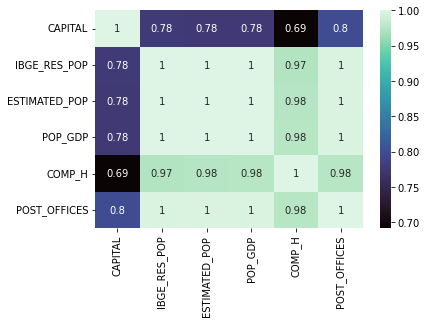

In [5]:
sns.heatmap(
    df[df_pop_cols].corr(),
    cmap='mako', annot=True
), df[df_pop_cols].corrwith(df.shipping_delay)

Etant donné que les variables sont toutes très corrélées entre elles, je ne prends que la meilleure correlation avec la cible

In [6]:
df_pop_cols.remove('COMP_H')
df = df.drop(columns=df_pop_cols + ['id', 'customer_id', 'customer_city', 'customer_state'], errors='ignore')
df = df.rename(columns={
    'COMP_H': 'customer_transport'
})
df.head(1)

,distance,estimated_delay,price,freight_value,seller_city,seller_state,weight,volume,cool_stuff,pet_shop,...,July,June,March,May,November,October,September,shipping_delay,seller_id,customer_transport
0,2400.386719,28.566238,21.99,14.11,sao paulo,SP,125.0,1040.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926,sao paulo SP,4825.0


Remplacement des valeurs vides par la mediane

In [7]:
print(df.customer_transport.isna().sum())
df.customer_transport = df.customer_transport.fillna(df.customer_transport.median())
df.customer_transport.isna().sum()

632


0

### Meme traitement pour les vendeurs

In [8]:
df_pop_cols = ['CAPITAL', 'IBGE_RES_POP', 'ESTIMATED_POP', 'RURAL_URBAN', 'POP_GDP', 'COMP_H', 'POST_OFFICES']
df = df.merge(df_pop, how='left', left_on='seller_id', right_on='id')

df[df_pop_cols].corrwith(df.shipping_delay)

CAPITAL         -0.086745
IBGE_RES_POP    -0.103065
ESTIMATED_POP   -0.102989
POP_GDP         -0.103003
COMP_H          -0.103294
POST_OFFICES    -0.103512
dtype: float64

Etant donné que les variables sont toutes très corrélées entre elles, je ne prends que la meilleure correlation avec la cible

In [9]:
df_pop_cols.remove('POST_OFFICES')
df = df.drop(columns=df_pop_cols + ['id', 'seller_id', 'seller_city', 'seller_state'], errors='ignore')
df = df.rename(columns={
    'POST_OFFICES': 'seller_post'
})
df.head(1)

,distance,estimated_delay,price,freight_value,weight,volume,cool_stuff,pet_shop,moveis_decoracao,perfumaria,...,July,June,March,May,November,October,September,shipping_delay,customer_transport,seller_post
0,2400.386719,28.566238,21.99,14.11,125.0,1040.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000926,4825.0,225.0


Remplacement des valeurs vides par la mediane

In [10]:
print(df.seller_post.isna().sum())
df.seller_post = df.seller_post.fillna(df.seller_post.median())
df.seller_post.isna().sum()

2394


0

In [11]:
y = df.pop('shipping_delay')
y = y.astype('float')

print(df.memory_usage().sum())
numeric_cols = df.select_dtypes(include=np.number).columns

# optimisation de taille
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, downcast="float")
y = y.apply(pd.to_numeric, downcast="float")

print(df.memory_usage().sum())

df.shape

80012200
40402200


(99025, 100)

# Feature selection et preprocessing

### Feature selection

Si je veux faire un formulaire avec mes données, je souhaite réduire au maximum mon nombre de variables 

( à 20 variables etant donné que les mois et produits sont très simples à renseigner )

La moitié des variables ont en absolu moins de 0.01 de correlation avec le temps de livraison

In [12]:
df.shape[1], (abs(df.corrwith(y)).sort_values(ascending=False) < 0.01).sum()

(100, 49)

65 variables on une P-value inferieures à 0.05

In [13]:
df.shape[1], (pd.Series(f_regression(df, y)[1]).sort_values(ascending=True) < 0.05).sum()

(100, 65)

In [14]:
df_cols = df.columns

selector = SelectKBest(f_regression, k=20)
X = pd.DataFrame(selector.fit_transform(df, y))
X.columns = df_cols[selector.get_support()]
print(X.shape, y.shape)
X.head(1)

(99025, 20) (99025,)


,distance,estimated_delay,price,freight_value,weight,volume,ferramentas_jardim,utilidades_domesticas,moveis_escritorio,Friday,August,December,February,January,July,June,March,November,customer_transport,seller_post
0,2400.386719,28.566238,21.99,14.11,125.0,1040.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4825.0,225.0


In [15]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='preprocessor_amelioration_input', con=con, if_exists='replace')
con.close()

### Pipeline

Certaines colonnes sont deja sous forme de OneHotEncoder

C'est pourquoi je ne les traite pas

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('do_nothing', SimpleImputer(strategy='constant', fill_value=-1))
])

categorical_features = X.columns[(~(X.nunique() > 2)).to_list()]
numeric_features = X.columns[(X.nunique() > 2).to_list()]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])
numeric_features

Index(['distance', 'estimated_delay', 'price', 'freight_value', 'weight',
       'volume', 'customer_transport', 'seller_post'],
      dtype='object')

In [17]:
X = pd.DataFrame(preprocessor.fit_transform(X))
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.449413,0.709033,-0.829501,-0.393858,-0.418558,-0.495045,0.095710,1.681786,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.008244,-0.083789,3.380557,1.066587,0.587374,0.444592,-0.566044,-0.149072,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.008244,-0.083789,3.380557,1.066587,0.587374,0.444592,-0.566044,-0.149072,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.094997,-0.690204,3.466915,0.693160,0.073707,-0.039203,2.185835,-0.149072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.745247,-0.077396,3.380557,0.909919,0.073707,-0.039203,-0.201944,-0.149072,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Sauvegarde du travail

In [18]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='X_amelioration', con=con, if_exists='replace')
y.to_sql(name='y_amelioration', con=con, if_exists='replace')
con.close()

In [19]:
from joblib import dump, load
from pathlib import Path

dossier_preprocessor = 'pickle/'
Path(dossier_preprocessor).mkdir(parents=True, exist_ok=True)
dump(preprocessor, dossier_preprocessor + 'preprocessor_amelioration' + '.pkl')

['pickle/preprocessor_amelioration.pkl']